In [24]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
import pickle
import warnings
import seaborn as sns
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import (cross_val_score, train_test_split)
import operator
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from matplotlib.ticker import MultipleLocator;
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## Load in existing dataset generated from previous YF algo

In [4]:
with open('/Users/jenniferhilibrand/Metis/Classification_ML/R3K_pickle.pickle', 'rb') as to_read: 
    ticker_data = pickle.load(to_read)
russel3k = pd.read_csv('/Users/jenniferhilibrand/Russel3K.csv')

In [7]:
with open('/Users/jenniferhilibrand/Metis/Classification_ML/R3K_pickle.pickle', 'rb') as to_read: 
    R3K_data= pickle.load(to_read)
boolean_series=ticker_data.Symbol.isin(russel3k['tickers'])
R3K_data=ticker_data[boolean_series]

## EDA

In [9]:
R3K_data['yf_sector'].value_counts()

Healthcare                586
Financial Services        513
Industrials               376
Technology                329
Consumer Cyclical         302
Real Estate               211
Consumer Defensive        119
Energy                    110
Communication Services    105
Basic Materials           100
Utilities                  68
Name: yf_sector, dtype: int64

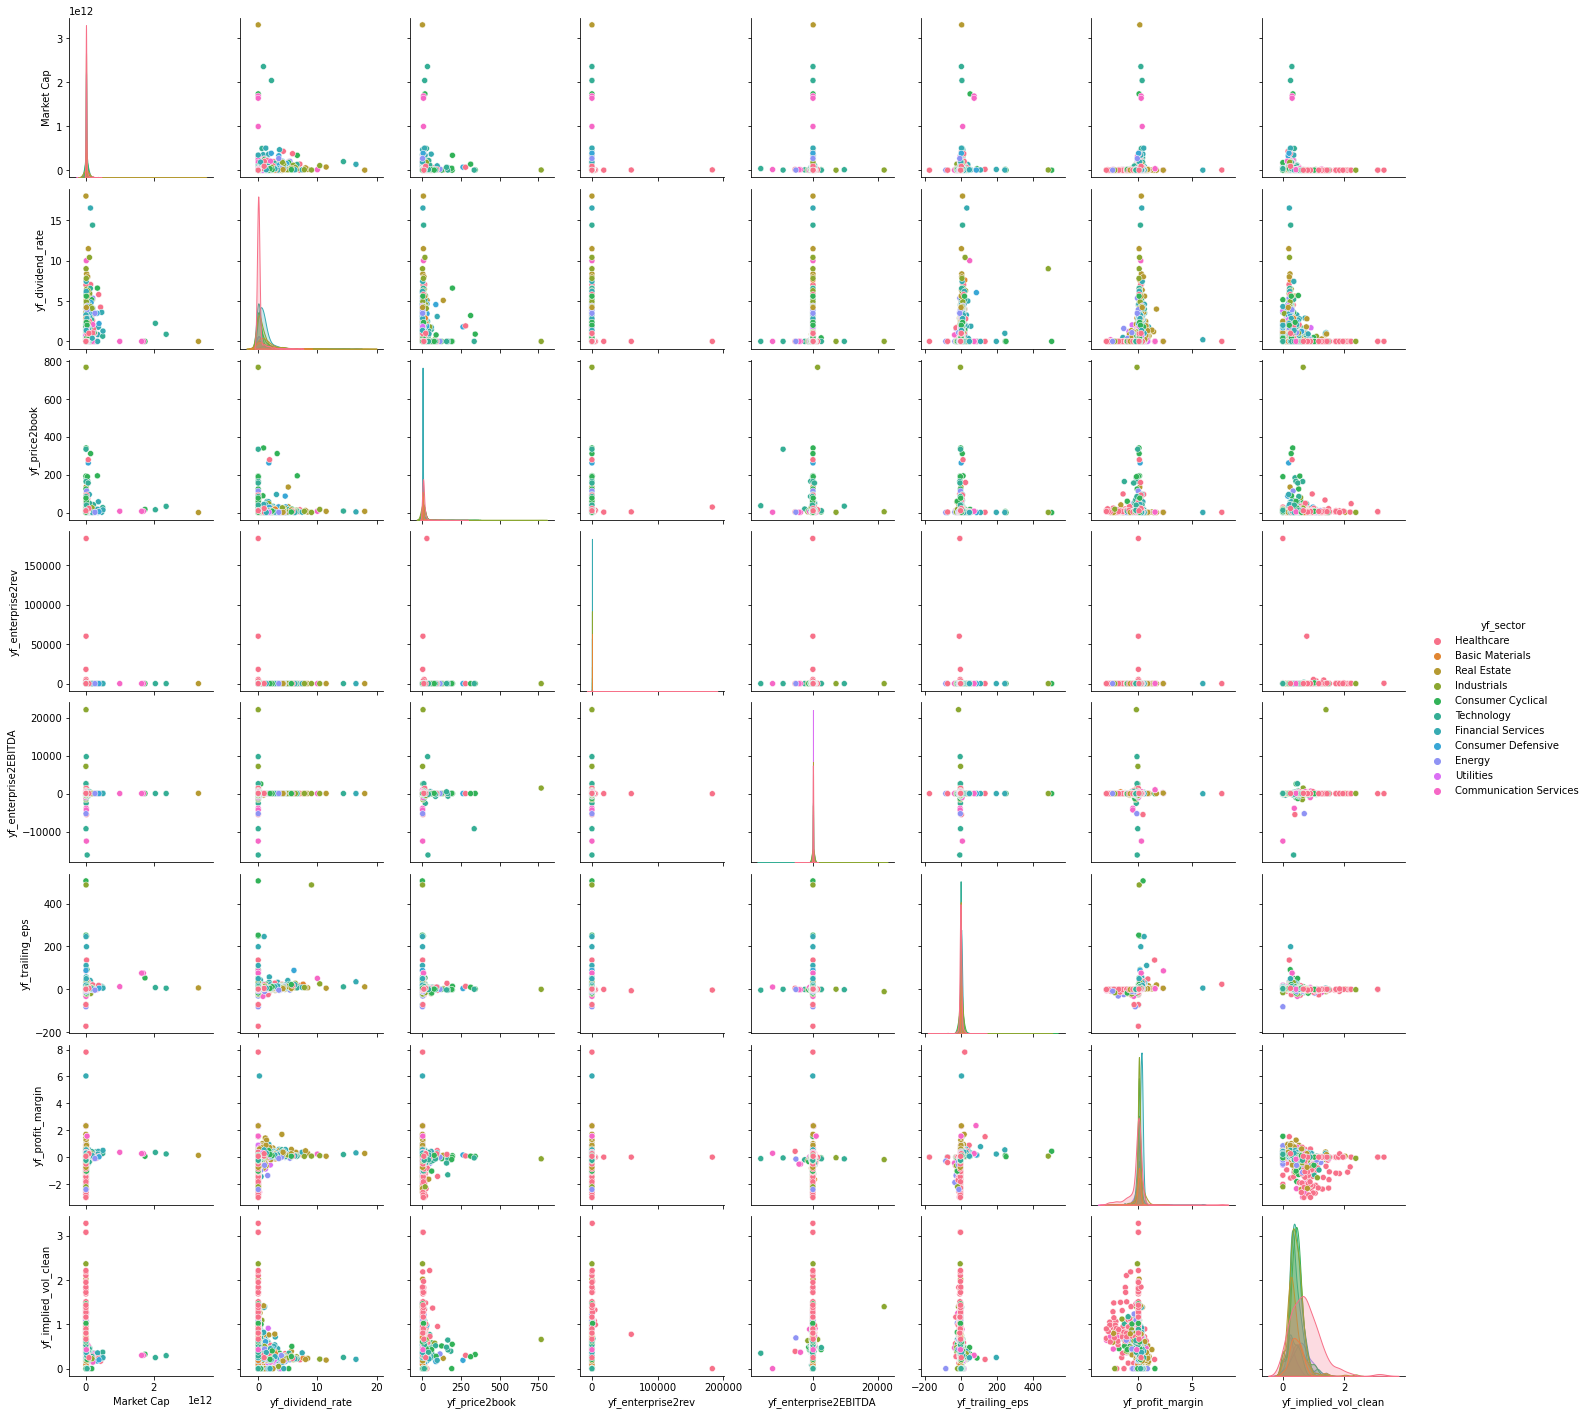

In [10]:
sns.pairplot(R3K_data, hue = 'yf_sector')

In [12]:
X_overall=R3K_data.loc[:,['Symbol','Market Cap', 'yf_dividend_rate', 'yf_price2book', 'yf_enterprise2rev', 'yf_enterprise2EBITDA', 'yf_trailing_eps', 'yf_profit_margin', 'yf_implied_vol_clean' ]]
Y_overall=R3K_data['yf_sector']
boolean_mask = Y_overall.isnull()
drop_me_index=Y_overall[boolean_mask].index
Y_overall.drop(drop_me_index,inplace=True)  
X_overall.drop(drop_me_index, inplace=True)
X_train_all, X_test, Y_train_all, Y_test = train_test_split(X_overall, Y_overall, test_size=0.2,random_state=44)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all, test_size=0.2,random_state=44)
X_test2=X_test.copy()
X_test=X_test.drop('Symbol', axis =1)
X_train2=X_train.copy()
X_train=X_train.drop('Symbol',axis =1)
X_val2=X_val.copy()
X_val=X_val.drop('Symbol',axis =1)

## Final version of XGBClassifier, post grid search for parameters

In [13]:
model = XGBClassifier(n_estimators = 100, learning_rate=0.4, objective="reg:squarederror", max_depth=3, subsample=1, gamma = 0, colsample_bytree=0.4)
model.fit(X_train, Y_train)
y_preds = model.predict(X_val)
accuracy_score(Y_val, y_preds)

[10:18:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.541019955654102

In [16]:
y_preds=model.predict(X_test)
output = pd.DataFrame(Y_test)
output['xgb1_preds']=y_preds
output['correct_pred_xgb1'] = (output['yf_sector']==output['xgb1_preds'])
y_preds_probs = model.predict_proba(X_test)
xgb_probs=[]
for i in y_preds_probs:
    xgb_probs.append(i)
output['xgb1_probs']=xgb_probs
output['symbol']=X_test2['Symbol']
class_array = model.classes_
xgb_dict_probs=[]
for i in xgb_probs:
    prob_dict=dict(zip(list(class_array),i))
    xgb_dict_probs.append(prob_dict)
output['xgb_prob_dict']=xgb_dict_probs
first_choice=[]
second_choice=[]
for i in xgb_dict_probs:
    x = sorted(((v,k) for k,v in i.items()))
    first_choice.append(x[-1][1])
    second_choice.append(x[-2][1])
output['first_choice']=first_choice
output['second_choice']=second_choice
output['second_choice_correct'] = (output['yf_sector']==output['second_choice'])
print("Top 2 Accuracy:",(sum(output['correct_pred_xgb1'])+sum(output['second_choice_correct']))/len(output['correct_pred_xgb1']))

Top 2 Accuracy: 0.6968085106382979


In [18]:
report = classification_report(Y_test, y_preds, output_dict=True, target_names=list(class_array))
class_list=[]
precision_list=[]
recall_list=[]
class_list = report.keys()
categories = list(class_array)
for i in categories:
    precision_list.append(report[i]['precision'])
    recall_list.append(report[i]['recall'])

stats = pd.DataFrame(recall_list)
stats['Precision']=precision_list

stats.rename(columns={0:'Recall'}, index={0:'Basic Materials', 1:"Communication Services", 2:'Consumer Cyclical', 3:"Consumer Defensive", 4:"Energy", 5:"Financial Services", 6:"Healthcare", 7:"Industrials", 8:"Real Estate", 9:"Technology", 10:"Utilities"}, inplace=True)
stats.style.background_gradient(cmap='GnBu').format("{:.2f}")

,Recall,Precision
Basic Materials,0.00,0.00
Communication Services,0.31,0.33
Consumer Cyclical,0.39,0.36
Consumer Defensive,0.11,0.21
Energy,0.36,0.42
Financial Services,0.84,0.85
Healthcare,0.72,0.64
Industrials,0.38,0.28
Real Estate,0.73,0.94
Technology,0.37,0.37


<AxesSubplot:>

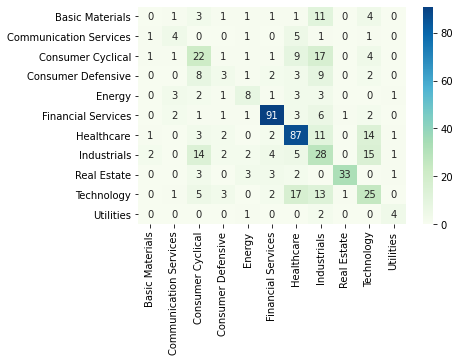

In [21]:
cf_matrix = confusion_matrix(Y_test, y_preds)
x_labels=list(class_array)
y_labels=list(class_array)
sns.heatmap(cf_matrix,xticklabels=x_labels,yticklabels=y_labels, annot=True,cmap='GnBu')

In [23]:
input_ticker='AAPL'
X_total = pd.concat([X_test, X_val, X_train])
Y_total = pd.concat([Y_test, Y_val, Y_train])
symbol_list = pd.concat([X_test2['Symbol'], X_val2['Symbol'], X_train2['Symbol']])
y_preds = model.predict(X_total)
overall_output = X_total
overall_output['true_sector'] = Y_total
overall_output['predicted_sector'] = y_preds
overall_output['symbol_list']=symbol_list
symbol_list = pd.concat([X_test2['Symbol'], X_val2['Symbol'], X_train2['Symbol']])


overall_output[overall_output['symbol_list']==input_ticker]
labels={"true_sector":"Sector","yf_dividend_rate":"Dividend Rate", "yf_price2book": "Price to Book", "yf_enterprise2EBITDA": "EV to EBITDA", "yf_trailing_eps": "Trailing EPS", "yf_profit_margin": "Profit Margin", "yf_enterprise2rev": "EV to Revenue","yf_implied_vol_clean": "Implied Vol", "Mkt_Cap_Bn": "Market Cap ($Bn)"}

sector_groupby = overall_output.groupby(['true_sector']).mean()
#sector_groupby.style.highlight_null('lightgray').highlight_max(color='lightgreen').highlight_min(color='pink').format("{:.2f}").background_gradient(cmap='Reds')
sector_groupby['Mkt_Cap_Bn']= sector_groupby['Market Cap']/1000000000
sector_groupby.drop('Market Cap', axis=1,  inplace=True)
sector_groupby.rename(columns=labels, inplace=True)
sector_groupby.style.highlight_null('lightgray').highlight_max(color='lightgreen').highlight_min(color='pink').format("{:.2f}").background_gradient(cmap='GnBu')


,Dividend Rate,Price to Book,EV to Revenue,EV to EBITDA,Trailing EPS,Profit Margin,Implied Vol,Market Cap ($Bn)
true_sector,,,,,,,,
Basic Materials,0.98,3.93,2.79,16.44,2.18,0.03,0.42,9.24
Communication Services,0.30,4.09,19.55,-157.32,2.57,-0.07,0.52,62.47
Consumer Cyclical,0.54,11.86,10.64,18.48,6.06,0.01,0.46,16.94
Consumer Defensive,1.00,8.85,2.82,15.10,3.46,0.01,0.33,23.89
Energy,0.50,3.69,8.61,-47.91,-3.25,-0.20,0.58,11.38
Financial Services,0.95,2.34,3.50,14.90,5.16,0.25,0.40,11.55
Healthcare,0.18,8.74,630.85,-0.45,-0.72,-0.22,0.74,10.13
Industrials,0.78,6.99,2.40,89.88,3.18,0.01,0.42,10.48
Real Estate,1.47,3.81,14.03,15.47,1.03,0.13,0.37,23.10


In [26]:
to_scale = overall_output.loc[:,['Market Cap', 'yf_dividend_rate', 'yf_price2book', 'yf_enterprise2rev', 'yf_enterprise2EBITDA', 'yf_trailing_eps', 'yf_profit_margin', 'yf_implied_vol_clean']]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(to_scale)
scaled_df = pd.DataFrame(scaled)
scaled_df['predicted']=overall_output['predicted_sector'].reindex(scaled_df.index)
pred=[]
for i in overall_output['predicted_sector']:
    pred.append(i)
scaled_df['predicted']=pred
true=[]
for i in overall_output['true_sector']:
    true.append(i)
scaled_df['true']=true
ticker=[]
for i in overall_output['symbol_list']:
    ticker.append(i)
scaled_df['ticker']=ticker
scaled_df.head(5)

,0,1,2,3,4,5,6,7,predicted,true,ticker
0,0.006938,0.082222,0.004771,0.001359,0.423185,0.262583,0.290385,0.099360,Technology,Basic Materials,VMC
1,0.000096,0.000000,0.003099,0.001335,0.422921,0.256663,0.282679,NaN,Consumer Cyclical,Consumer Defensive,NATR
2,0.000138,0.038889,0.000320,0.001365,0.422957,0.250073,0.276621,0.237428,Real Estate,Real Estate,APTS
3,0.000025,0.022222,0.002409,0.001334,0.422990,0.255112,0.277615,NaN,Industrials,Industrials,BGSF
4,0.000083,0.004444,0.001178,0.001332,0.423044,0.257048,0.278481,0.213654,Industrials,Basic Materials,ZEUS


In [45]:
input_ticker='NFLX'

input_row = scaled_df[scaled_df['ticker']==input_ticker]
input_true = input_row['true']
input_predicted = input_row['predicted']
single_sector = scaled_df[scaled_df['true']== input_true.iloc[0]]
sector_tickers=[]
for i in single_sector['ticker']:
    sector_tickers.append(i)
dist_list = []

input_row_clean = input_row.iloc[:,0:7].dropna(axis=1)
calc_cols = input_row_clean.columns
single_sector = single_sector[calc_cols]
single_sector_clean=single_sector 


for index, row in single_sector_clean.iterrows():
    dist_list.append(np.linalg.norm(row - input_row_clean))
recommender_df = pd.DataFrame(dist_list)
recommender_df['ticker']=sector_tickers
top = recommender_df.sort_values(by=[0])
for i in top[1:6]['ticker']:
    print(i)

TMUS
CHTR
DIS
ATVI
CMCSA


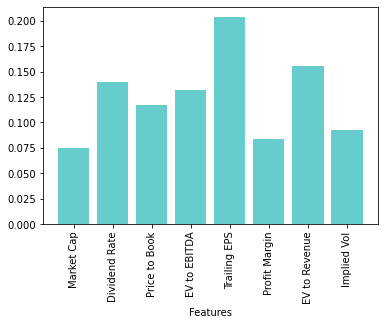

In [40]:
import matplotlib.pyplot as plt
x_labels = ["Market Cap", "Dividend Rate","Price to Book", "EV to EBITDA",  "Trailing EPS", "Profit Margin",  "EV to Revenue", "Implied Vol"]  
plt.bar(range(len(model.feature_importances_)), model.feature_importances_, color = '#66CCCC')
plt.xticks(range(len(model.feature_importances_)),x_labels, rotation = 90)
plt.xlabel('Features')
plt.show()